# Patterns Mining & Association Rules, is clustering improving?
Mining frequent patterns and association rules over the [House prices dataset (Kaggle)](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) <br> 



### 0. Imports

In [46]:
#data processing
import pandas as pd
import numpy as np
import scipy as sp

#statistics
from scipy import stats
import statsmodels.api as sm


#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


#Machine learning library
import sklearn

#Patterns Mining
from efficient_apriori import apriori

import warnings
warnings.filterwarnings("ignore")
import utils

##### Loading the CSV dataset

In [88]:
dataset_path = "./datasets/Telecust1.csv"
dtf = pd.read_csv(dataset_path)

In [89]:
dtf.head(10)

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside,custcat
0,2,13,44,64,1,9,4,5,0,0,2,A
1,3,11,33,136,1,7,5,5,0,0,6,D
2,3,68,52,116,1,24,1,29,0,1,2,C
3,2,33,33,33,0,12,2,0,0,1,1,A
4,2,23,30,30,1,9,1,2,0,0,4,C
5,2,41,39,78,0,17,2,16,0,1,1,C
6,3,45,22,19,1,2,2,4,0,1,5,B
7,2,38,35,76,0,5,2,10,0,0,3,D
8,3,45,59,166,1,7,4,31,0,0,5,C
9,1,68,41,72,1,21,1,22,0,0,3,B


In [90]:
#check if any column is null
dtf.isnull().any()

region     False
tenure     False
age        False
income     False
marital    False
address    False
ed         False
employ     False
retire     False
gender     False
reside     False
custcat    False
dtype: bool

####Drop possibly problematic columns

In [92]:
## CustomerID, TransactionDate and StoreLocation are date and text which we cant really use
dtf = dtf.drop(columns=['CustomerID', 'TransactionDate', 'StoreLocation'])

##### Defining numeric and categorical columns

In [93]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
very_numerical = [nc for nc in numeric_columns if dtf[nc].nunique()>20]
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]
ordinals = list(set(numeric_columns) - set(very_numerical))

##### Filling Null Values with the column's mean

In [94]:
na_columns = dtf[very_numerical].isna().sum()
na_columns = na_columns[na_columns>0]
for nc in na_columns.index:
    dtf[nc].fillna(dtf[nc].mean(),inplace=True)

##### Dropping and filling NA values for categorical columns:

1. drop if at least 70% are NA:

In [95]:
nul_cols = dtf[categorical_columns].isna().sum()/len(dtf)
drop_us = nul_cols[nul_cols>0.7]

In [96]:
dtf=dtf.drop(drop_us.index,axis=1)
categorical_columns = list(set(categorical_columns)-set(drop_us.index))

2. Fill with a new 'na' category:

In [97]:
dtf[categorical_columns]= dtf[categorical_columns].fillna('na')

##### one hot encoding/lable encoding Categorical data for clustreing

In [98]:
dtf_encoded = utils.label_encoding(dtf.copy(), categorical_columns)
dtf_encoded.dtypes

region     int64
tenure     int64
age        int64
income     int64
marital    int64
address    int64
ed         int64
employ     int64
retire     int64
gender     int64
reside     int64
custcat    int32
dtype: object

#### Find best k

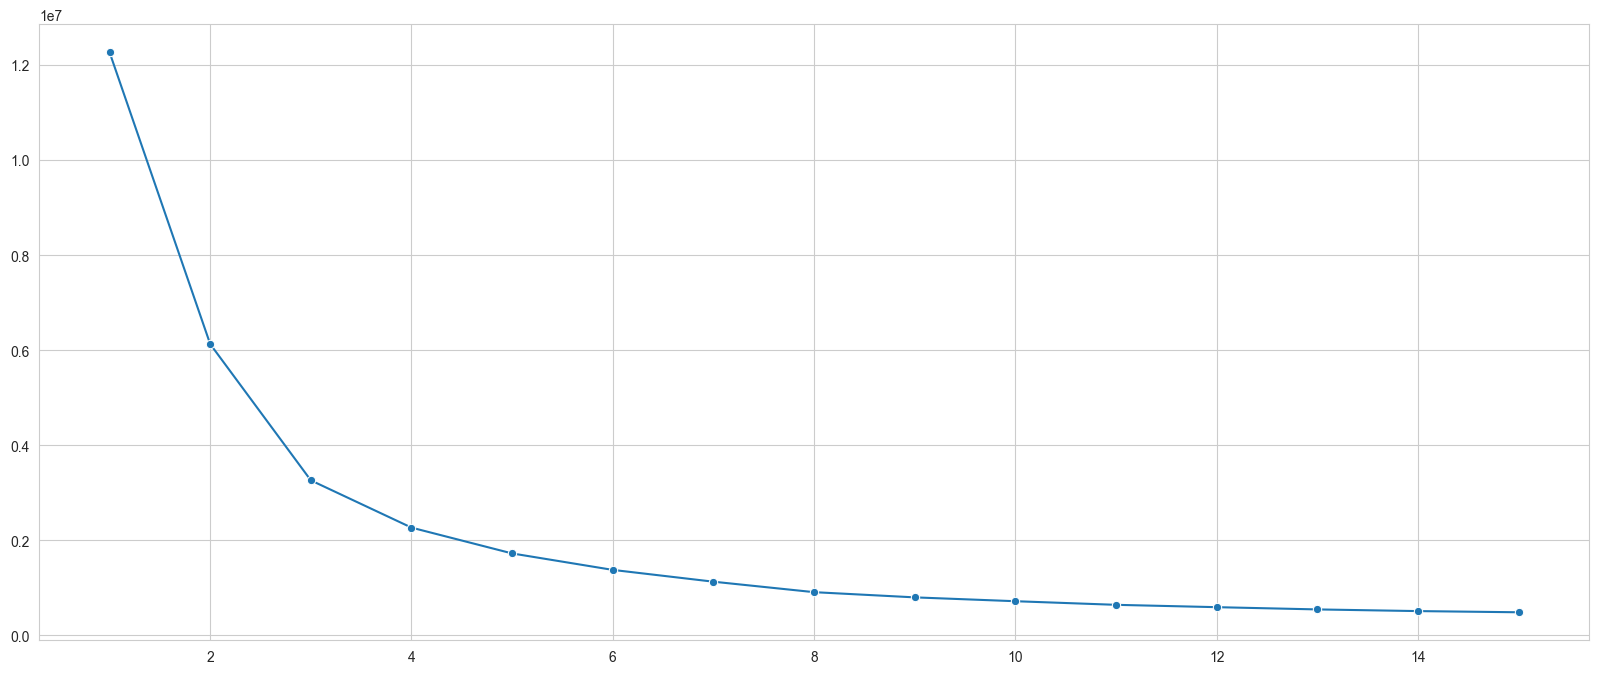

In [99]:
utils.opt_kmeans(dtf_encoded,15)

In [100]:
clusters = utils.run_k_means(6,dtf_encoded,dtf)
lens = [len(a) for a in clusters.values()]
lens

[236, 12, 682, 66, 3, 1]

##### removing small clusters

In [101]:
labels2remove = []
for label,cdf in clusters.items():
    print(len(cdf))

    #removing clusters under 1% in size. this is just so we dont get things with very high relative support
    if len(cdf) < len(dtf)/100:
        labels2remove.append(label)
for label in labels2remove:
    del clusters[label]
len(clusters)


236
12
682
66
3
1


4

### 2. Using Apriori on a each cluster:

### Preprocessing clusters for apriori

In [102]:
clusters[list(clusters.keys())[0]][:1]

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside,custcat
1,3,11,33,136,1,7,5,5,0,0,6,D


In [103]:
for label,cdf in clusters.items():
    clusters[label] = utils.preprocess_4_apriori(cdf,very_numerical)
clusters[list(clusters.keys())[0]]

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside,custcat
1,3,very low,very low,very high,1,low,5,very low,0,0,6,D
2,3,very high,high,high,1,high,1,very high,0,1,2,C
5,2,low,very low,very low,0,medium,2,low,0,1,1,C
7,2,low,very low,very low,0,very low,2,very low,0,0,3,D
8,3,low,very high,very high,1,low,4,very high,0,0,5,C
...,...,...,...,...,...,...,...,...,...,...,...,...
977,3,low,high,very high,0,medium,4,low,0,0,2,A
979,2,medium,low,low,0,high,1,high,0,1,1,C
988,1,very high,low,very high,1,high,4,low,0,0,2,B
992,1,low,high,medium,1,very low,2,medium,0,0,2,C


In [104]:
clusters[list(clusters.keys())[0]][:1]

,region,tenure,age,income,marital,address,ed,employ,retire,gender,reside,custcat
1,3,very low,very low,very high,1,low,5,very low,0,0,6,D


In [105]:
#might need to select only several columns for running effiency
patitioned_total_rules = set()

for label,cdf in clusters.items():
    transactions = utils.convert_ds_to_transactions(cdf)
    itemsets, rules = apriori(transactions, min_support=0.5, min_confidence=0.8,output_transaction_ids=False)
    print(len(patitioned_total_rules))
    patitioned_total_rules.update(rules)

patitioned_total_rules=list(patitioned_total_rules)
len(patitioned_total_rules)

0
2
10
10


10

### do apriori on the initial dataset for comparison

In [130]:
transactions = utils.convert_ds_to_transactions(dtf)
unpatitioned_total_itemsets, unpatitioned_total_rules = apriori(transactions, min_support=0.4, min_confidence=0.6,output_transaction_ids=False)
#print(rules)  # [{eggs} -> {bacon}, {soup} -> {bacon}]

In [131]:
len(unpatitioned_total_rules)

4

## 2. Analyzing the rules:
We need a measures of interestingness to evaluate our results.

We first use the Lift measurement taught in class.
on top of that we use the Conviction and Leverage measurements.
formulas and meaning of those can be seen in the report file.

### Lift comparison

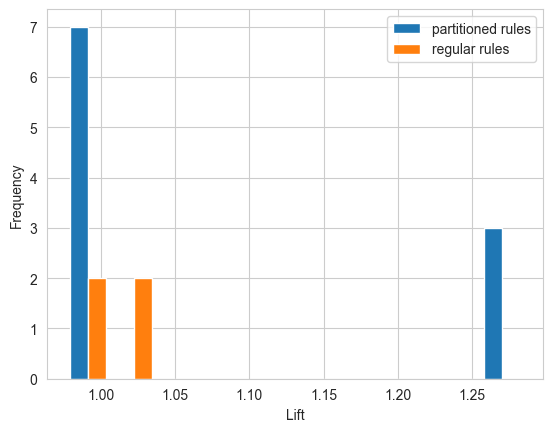

In [132]:
partitioned_lift_arr = [rule.lift for rule in patitioned_total_rules]
unpartitioned_lift_arr = [rule.lift for rule in unpatitioned_total_rules]
plt.hist([partitioned_lift_arr,unpartitioned_lift_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Lift')
plt.ylabel('Frequency')

plt.show()

### Conviction comparison

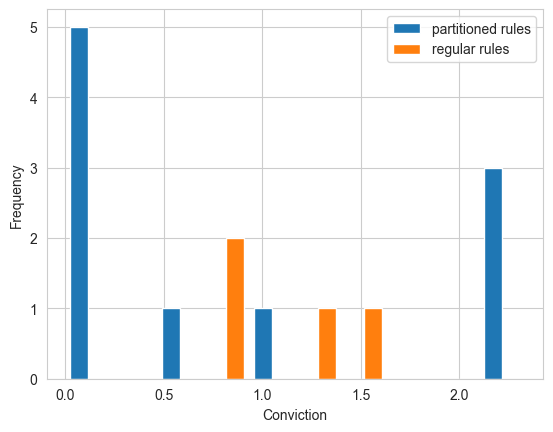

In [133]:
#creating conviction graph for both the partitioned rules and the unpartitioned rules
partitioned_conviction_arr = [rule.conviction for rule in patitioned_total_rules]
unpartitioned_conviction_arr = [rule.conviction for rule in unpatitioned_total_rules]
plt.hist([partitioned_conviction_arr,unpartitioned_conviction_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Conviction')
plt.ylabel('Frequency')

plt.show()

### Confidence comparison


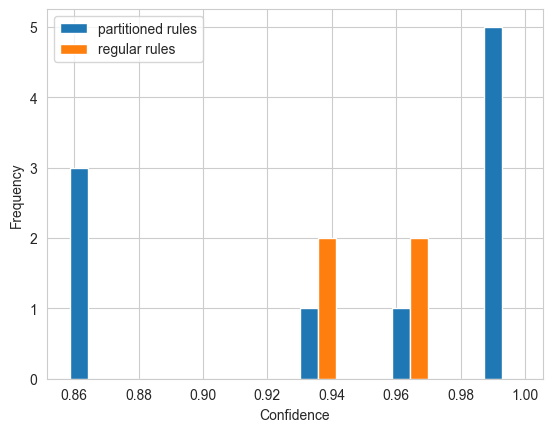

In [134]:
partitioned_conf_arr = [rule.confidence for rule in patitioned_total_rules]
unpartitioned_conf_arr = [rule.confidence for rule in unpatitioned_total_rules]
plt.hist([partitioned_conf_arr,unpartitioned_conf_arr])
plt.legend(['partitioned rules','regular rules'])
plt.xlabel('Confidence')
plt.ylabel('Frequency')

plt.show()